C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported i

Holt-Winters - RMSE: 0.0377, R²: 0.9402, KGE: 0.8661
ARIMA - RMSE: 0.0123, R²: 0.9937, KGE: 0.9562


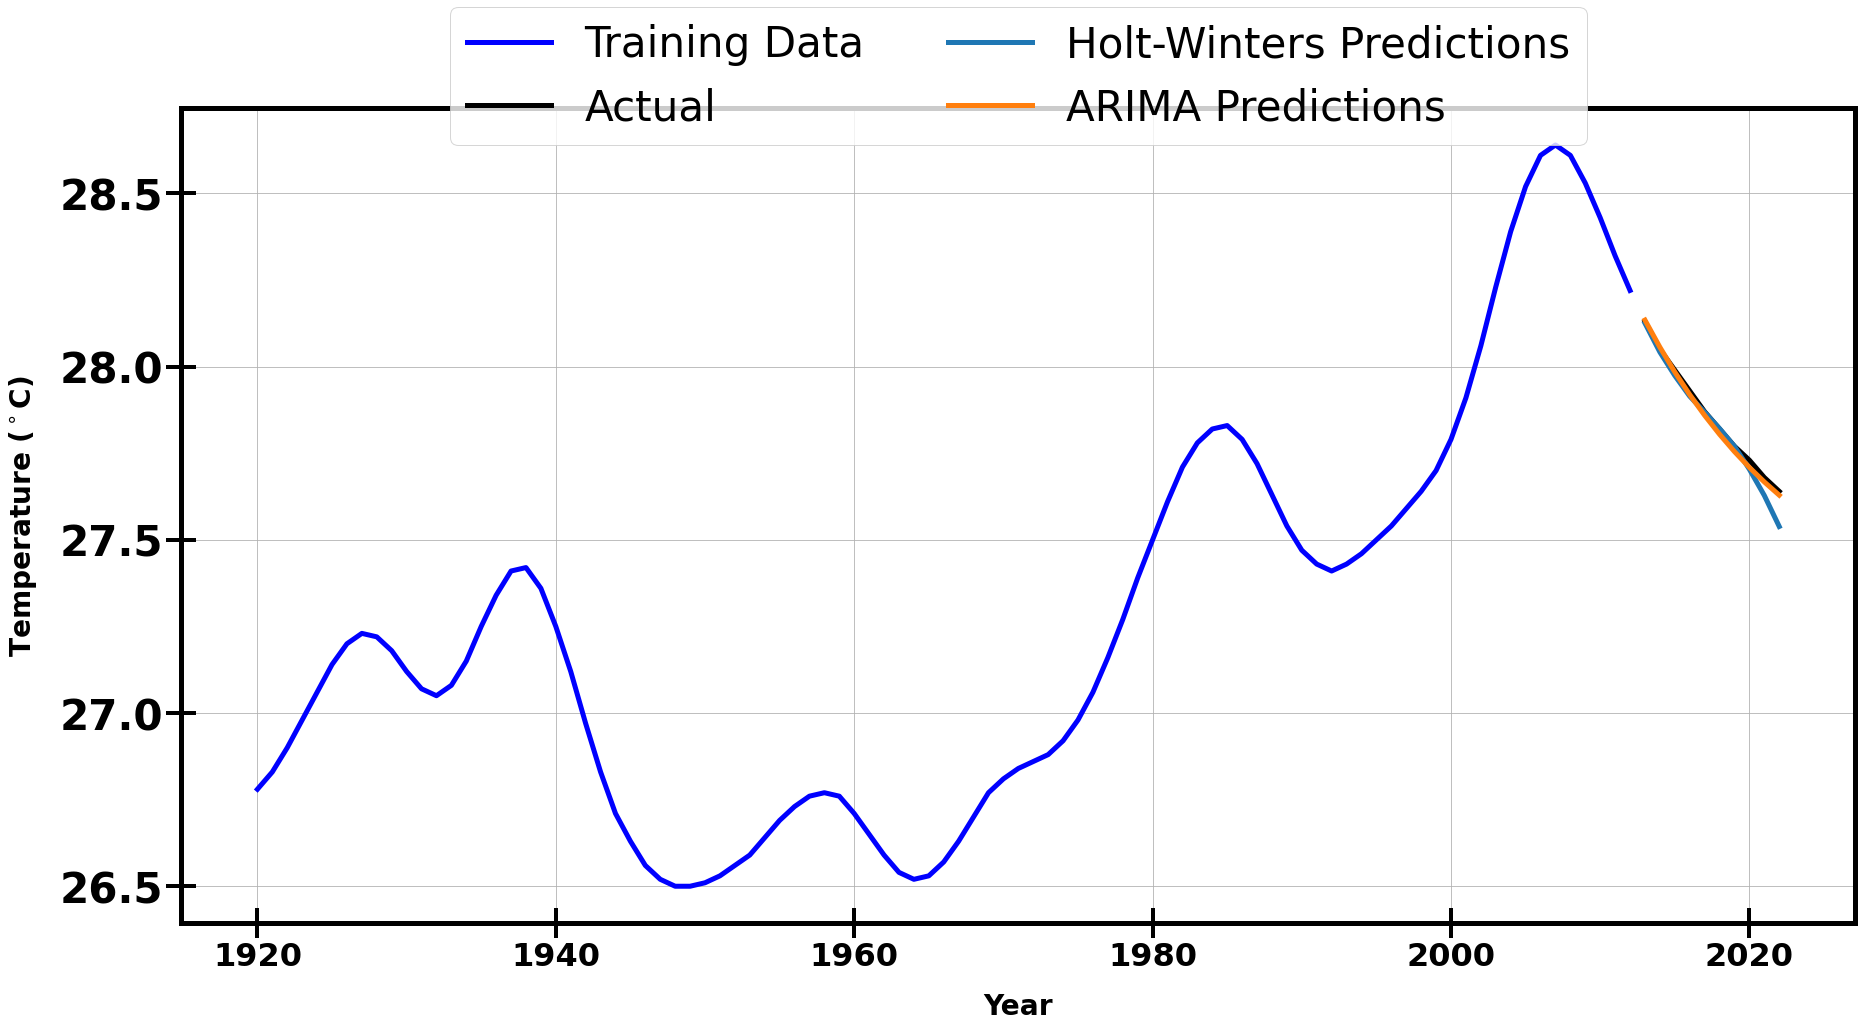

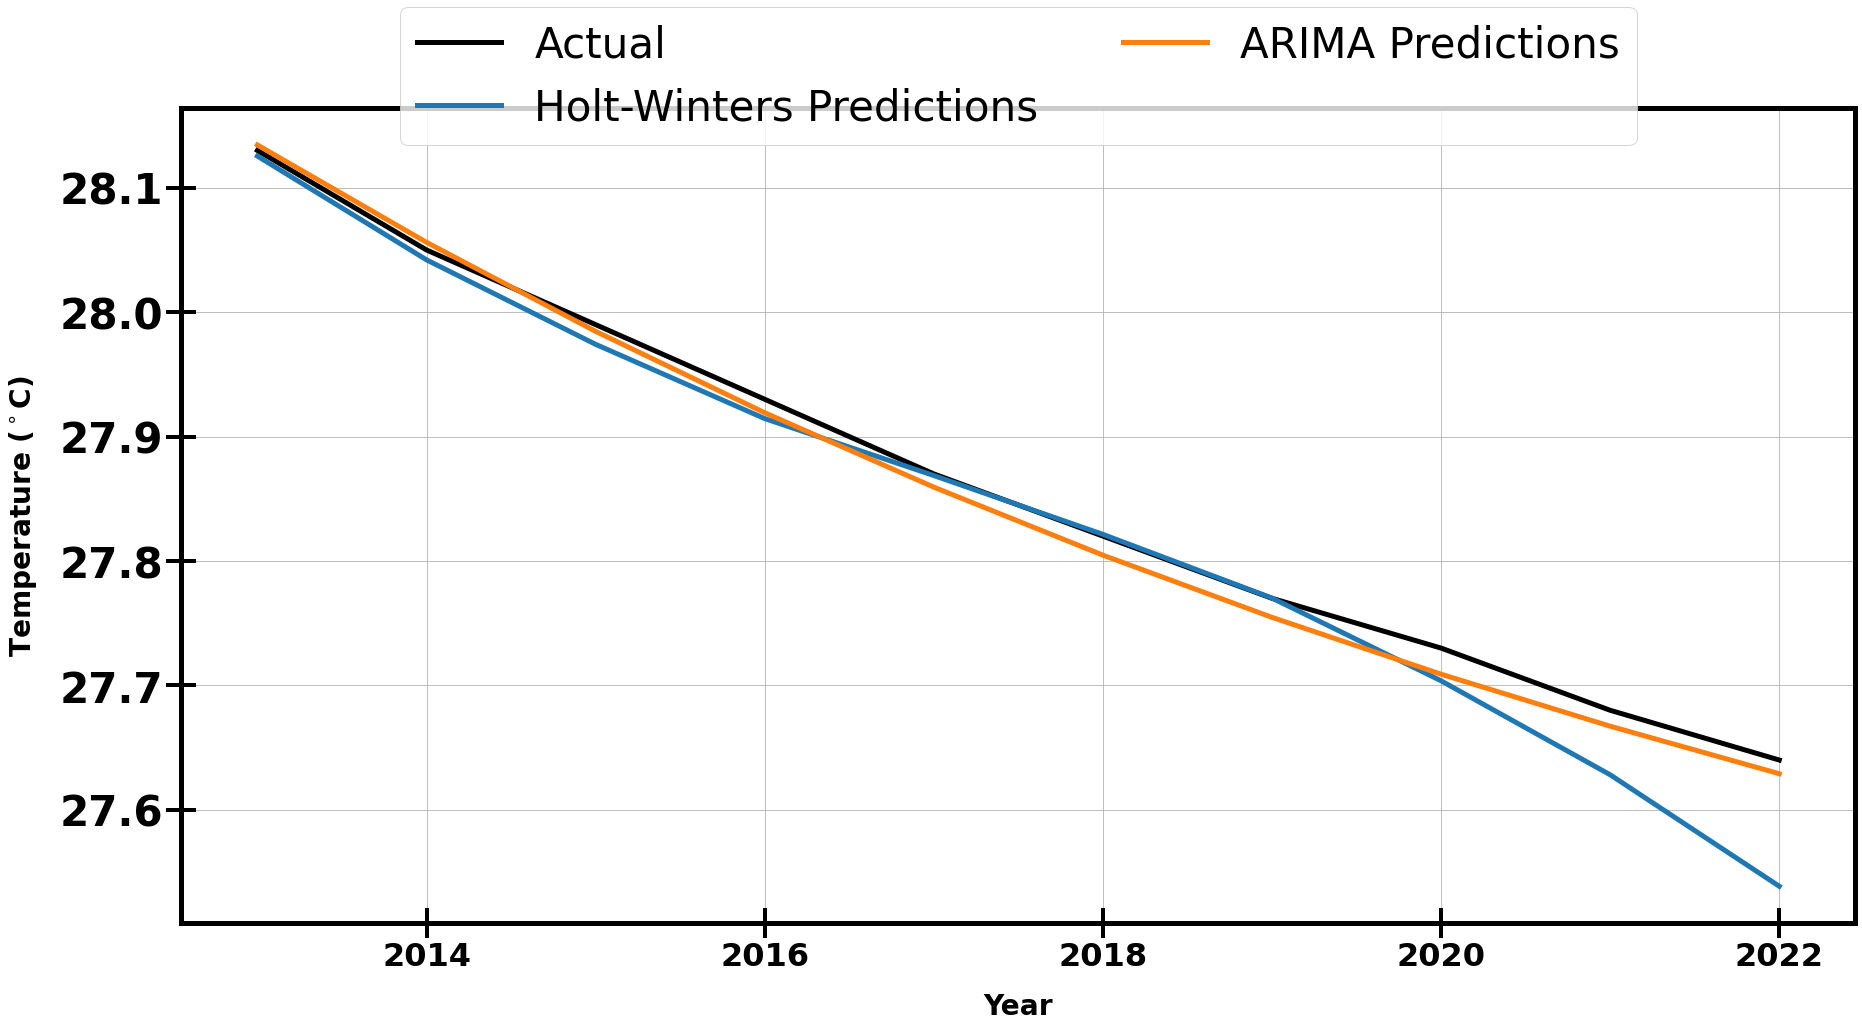

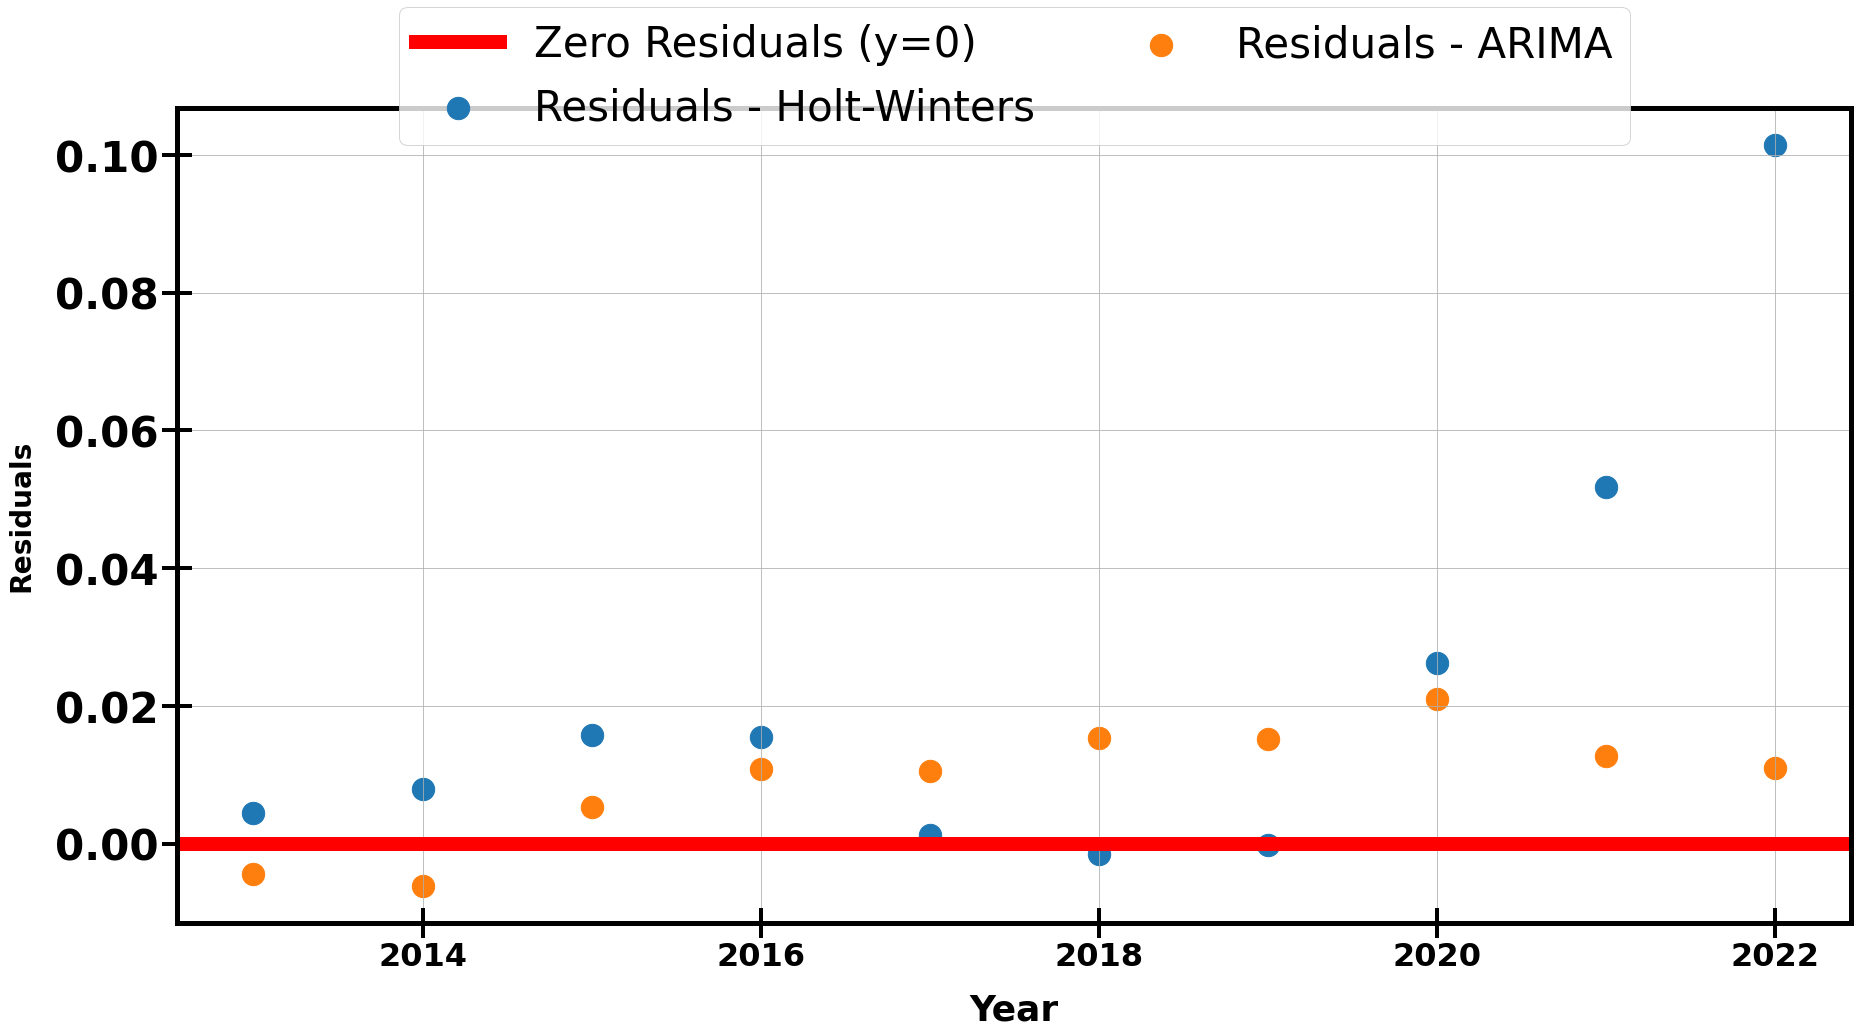

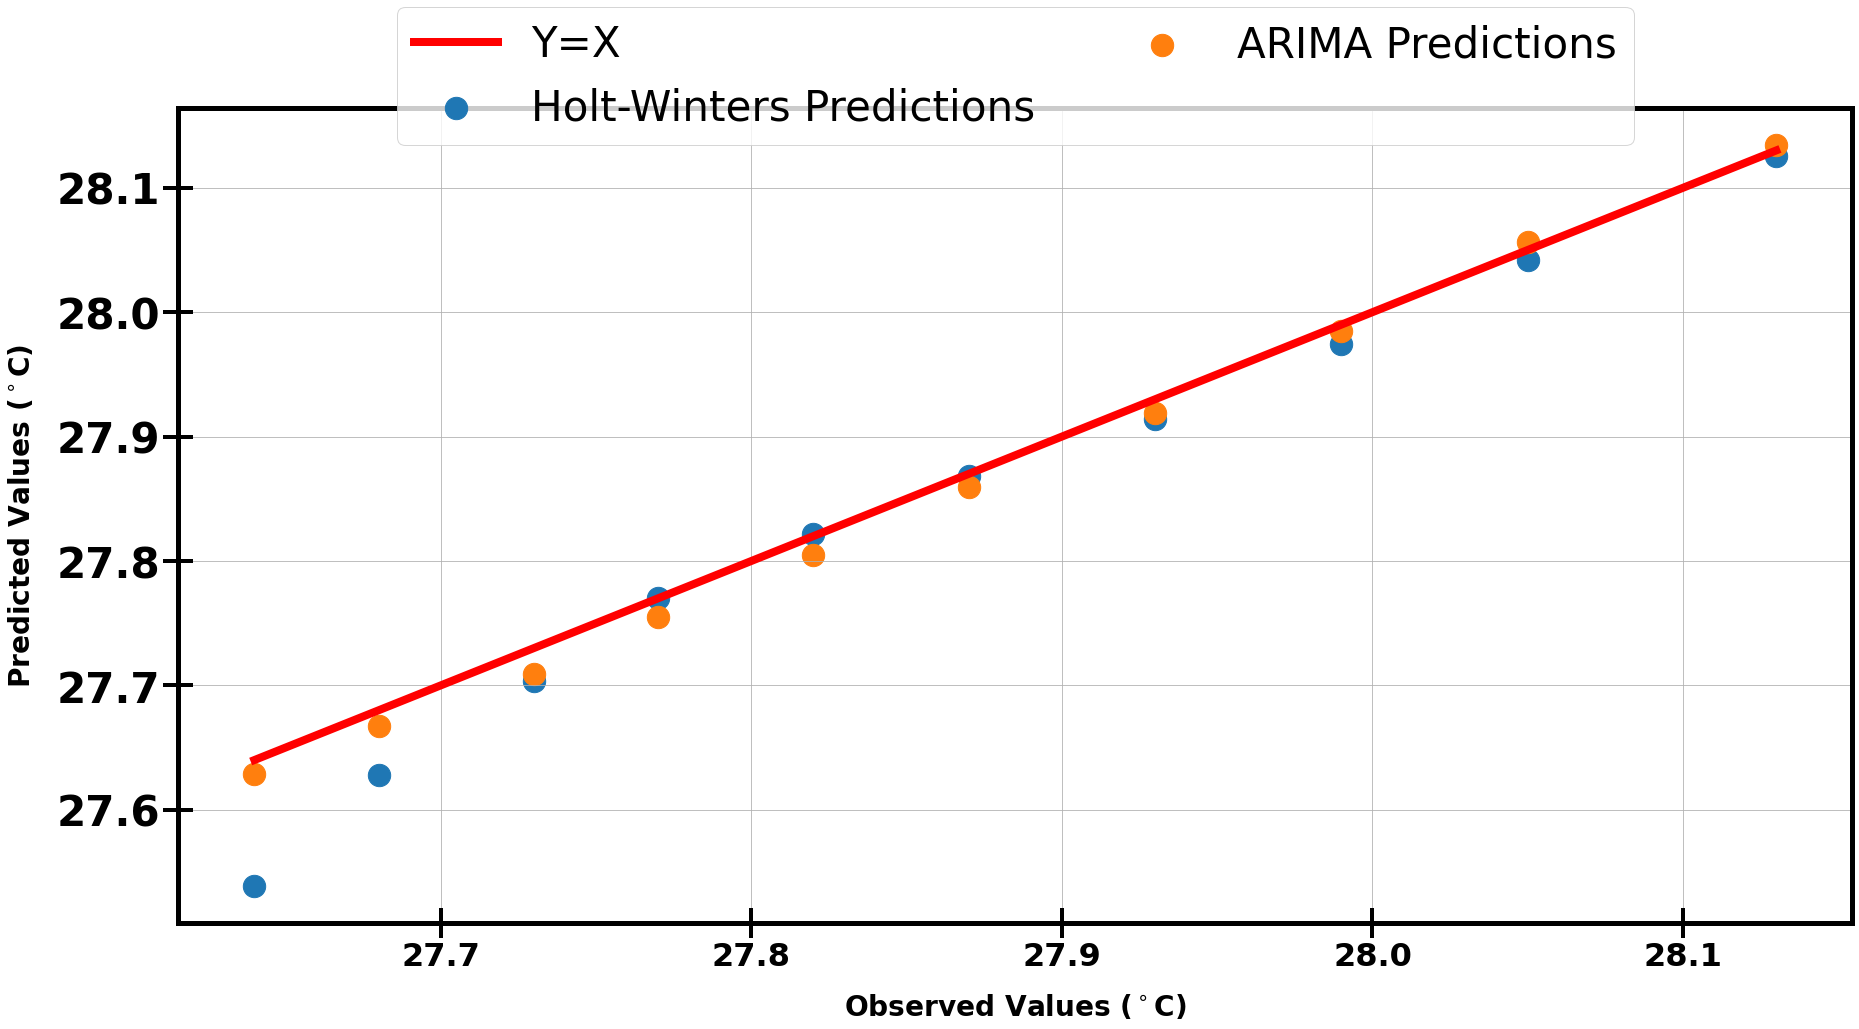

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA
from sklearn.metrics import mean_squared_error, r2_score

# Load Data
data = pd.read_csv('data.csv')  # Ensure filename matches
data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']  # Ensure proper column names
data = data[['Year', 'Smooth_5yr']]
data = data[data["Year"] >= 1920]
data.set_index('Year', inplace=True)

# Outlier Handling (using rolling and exponential smoothing)
def outlier_removal(df, window=5, alpha=0.1):
    df['Rolling_Mean'] = df['Smooth_5yr'].rolling(window=window).mean()
    df['Exponential_Smoothing'] = df['Smooth_5yr'].ewm(span=window, adjust=False).mean()
    df['Outlier_Enhanced'] = np.where(abs(df['Smooth_5yr'] - df['Exponential_Smoothing']) > 2 * df['Smooth_5yr'].std(), df['Exponential_Smoothing'], df['Smooth_5yr'])
    return df

df = outlier_removal(data)

# Split Data into Training (1990-1999), Validation (2000-2014), and Testing (2015-2025)
train_data = df[df.index <= 2012]
valid_data = df[(df.index > 2012) & (df.index <= 2022)]
test_data = df[df.index > 2022]

# Features and Target
y_train = train_data['Outlier_Enhanced']
y_valid = valid_data['Outlier_Enhanced']
y_test = test_data['Outlier_Enhanced']

# Define Models (removing SARIMA)
models = {
    "Holt-Winters": ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12),
    "ARIMA": ARIMA(y_train, order=(1, 1, 1))
}

# Function to Calculate Kling-Gupta Efficiency (KGE)
def kling_gupta_efficiency(observed, predicted):
    r = np.corrcoef(observed, predicted)[0, 1]
    beta = np.mean(predicted) / np.mean(observed)
    alpha = np.std(predicted) / np.std(observed)
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

# Function for Model Training and Evaluation
def train_and_evaluate(model, model_name):
    model_fitted = model.fit()
    predictions = model_fitted.forecast(steps=len(y_valid))

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    r2 = r2_score(y_valid, predictions)
    kge = kling_gupta_efficiency(y_valid.values, predictions)

    return rmse, r2, kge, predictions

# Evaluate All Models
results = {}
predictions_dict = {}
for model_name, model in models.items():
    rmse, r2, kge, predictions = train_and_evaluate(model, model_name)
    results[model_name] = {"RMSE": rmse, "R²": r2, "KGE": kge}
    predictions_dict[model_name] = predictions

# Display Results
for model_name, result in results.items():
    print(f"{model_name} - RMSE: {result['RMSE']:.4f}, R²: {result['R²']:.4f}, KGE: {result['KGE']:.4f}")

# Plotting Actual vs Predicted for All Models



# Define the directory to save the plots
output_dir = 'output_plots'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

plt.figure(figsize=(30, 15))
plt.plot(train_data.index, y_train, label='Training Data', color='blue', linewidth=5)
plt.plot(valid_data.index, y_valid, label='Actual', color='black', linewidth=5)
for model_name, predictions in predictions_dict.items():
    plt.plot(valid_data.index, predictions, label=f'{model_name} Predictions', linewidth=5)
# plt.title('Actual vs Predicted Temperature (Enhanced)')
plt.xlabel('Year', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Temperature ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=42)

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'training_vs_observed_vs_prediction.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Plotting Actual vs Predicted for All Models
plt.figure(figsize=(30, 15))
# plt.plot(train_data.index, y_train, label='Training Data', color='blue', linewidth=2)
plt.plot(valid_data.index, y_valid, label='Actual', color='black', linewidth=5)
for model_name, predictions in predictions_dict.items():
    plt.plot(valid_data.index, predictions, label=f'{model_name} Predictions',linewidth=5)
# plt.title('Actual vs Predicted Temperature (Enhanced)')
plt.xlabel('Year',fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Temperature ($^\circ$C)',fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=42)

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'observed_vs_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot


# 
# Plot Residuals (Actual - Predicted)
plt.figure(figsize=(30, 15))  # Adjust the size (14, 8) to your preferred dimensions

for model_name, predictions in predictions_dict.items():
    residuals = y_valid.values - predictions  # Ensure the same length for residuals
    plt.scatter(valid_data.index, residuals, label=f'Residuals - {model_name}', alpha=1, s=500)

plt.axhline(y=0, color='r', linestyle='-', label='Zero Residuals (y=0)', linewidth=14)
# plt.title('Prediction Residuals', fontsize=40, fontweight='bold')
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=20)
plt.ylabel('Residuals', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=42)

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'residuals_vs_observed.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot


# Scatter plot of predictions against observed values
plt.figure(figsize=(30, 15))
for model_name, predictions in predictions_dict.items():
    plt.scatter(y_valid, predictions, label=f'{model_name} Predictions', alpha=1, s=500)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], color='red', linestyle='-', label='Y=X', linewidth=8)
# plt.title('Scatter Plot: Predictions vs Observed')
plt.xlabel('Observed Values ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Predicted Values ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=42)
# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'scatter_predictions_vs_observed.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot




In [2]:
3+3

6